Atividade final da disciplina de Visão Robótica

Discente: Henrique Antônio Guanais Corneau

# Reconstrução 3D e georreferenciamento a partir do mapa de disparidade

Nessa primeira parte do programa, apenas irão ser inicializadas algumas variáveis e conversões de escala de cor.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from measure_distance import DistanceMeter
from gps_mark import GPSMarker

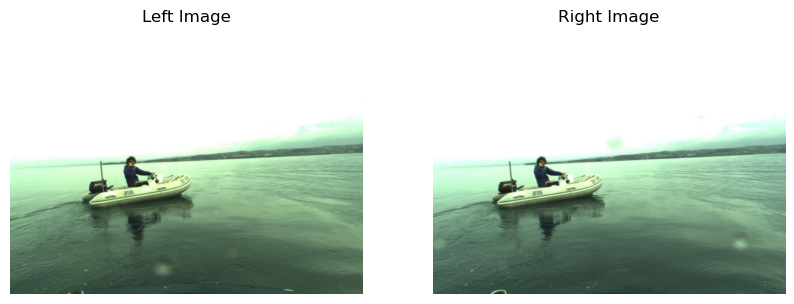

In [2]:
# imagem esquerda e direita
left_image = cv2.imread("../dataset/MODD/frames/00013824L.jpg")
right_image = cv2.imread("../dataset/MODD/frames/00013824R.jpg")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))
plt.title('Left Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB))
plt.title('Right Image')
plt.axis('off')
plt.show()

In [3]:
# obter os parametros de calibracao da camera a partir do arquivo de calibracao
calibration_dir = "../dataset/MODD/calibration.yaml"
calibration_file = cv2.FileStorage(calibration_dir, cv2.FILE_STORAGE_READ)
Kl = np.array(calibration_file.getNode('M1').mat())
Dl = np.array(calibration_file.getNode('D1').mat())
Kr = np.array(calibration_file.getNode('M2').mat())
Dr = np.array(calibration_file.getNode('D2').mat())
R = np.array(calibration_file.getNode('R').mat())
T = np.array(calibration_file.getNode('T').mat())   
calibration_file.release()

print('Left camera:')
print(Kl)
print('Left camera distortion:')
print(Dl)
print('Right camera:')
print(Kr)
print('Right camera distortion:')
print(Dr)
print('Rotation matrix:')
print(R)
print('Translation:')
print(T)

Left camera:
[[957.7950706    0.         656.23724898]
 [  0.         956.99355408 538.41903131]
 [  0.           0.           1.        ]]
Left camera distortion:
[[-3.67679344e-01]
 [ 2.03381397e-01]
 [ 2.07905790e-04]
 [ 4.68656691e-04]
 [-7.56255767e-02]]
Right camera:
[[957.1114608    0.         641.71133185]
 [  0.         956.12071851 502.87401404]
 [  0.           0.           1.        ]]
Right camera distortion:
[[-3.66992989e-01]
 [ 2.05628665e-01]
 [ 2.41385031e-04]
 [-3.40254028e-04]
 [-7.92577706e-02]]
Rotation matrix:
[[ 9.99959238e-01  1.20322305e-04 -9.02818929e-03]
 [-8.24866241e-05  9.99991214e-01  4.19109356e-03]
 [ 9.02861425e-03 -4.19017801e-03  9.99950462e-01]]
Translation:
[[-356.38806655]
 [  -0.52120595]
 [  -2.66188526]]


458 553
639 479


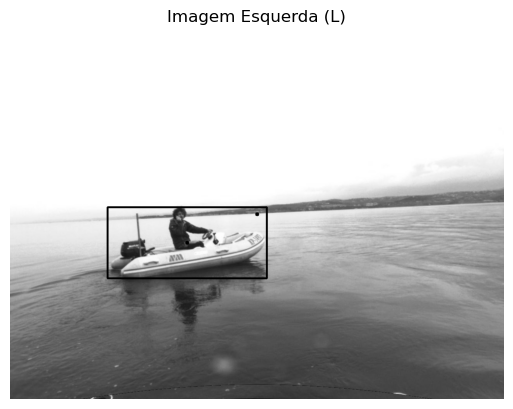

In [4]:
focal_length = Kl[0, 0]  
baseline = T[0, 0] / -1000

# coordendas da ROI (Region of Interest)
x, y, w, h = 252, 461, 412, 184
center_x = x + w/2
center_y = y + h/2
# declinacao magnetica (Golfo de Koper, Eslovênia)
magnetic_declination = 4.41
print(int(center_x), int(center_y))
# converter imagem para escala de cinza
imgL = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
imgR = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)
print(int(imgL.shape[1]/2), int(imgL.shape[0]/2))

stereo_method_file = "../dataset/MODD/stereo-method.yaml"
gps_path = '../dataset/MODD/gps.txt'
imu_path = '../dataset/MODD/imu.txt'

# exibicao da imagem com o bounding box, e em preto o centro da imagem e o centro da ROI
imgL_temp = np.copy(imgL)
cv2.rectangle(imgL_temp, (x, y), (x+w, y+h), (0, 0, 255), 3)
cv2.circle(imgL_temp, (int(center_x), int(center_y)), 5, (0, 0, 255), -1)
cv2.circle(imgL_temp, (int(imgL_temp.shape[1]/2), int(imgL_temp.shape[0]/2)), 5, (0, 0, 255), -1)
plt.imshow(cv2.cvtColor(imgL_temp, cv2.COLOR_BGR2RGB))
plt.title("Imagem Esquerda (L)")
plt.axis('off')
plt.show()

Para a criação do mapa de disparidade, está sendo declarado o objeto `DistanceMeter()`, que leva em consideração a distância focal e o baseline da câmera. 

Para que dê certo o cálculo, é necessário carregar os parâmetros de configuração do método estéreo, que está sendo feito em `distance_meter.load_stereo_params(stereo_method_file)`.

Posteriormente, o mapa de disparidade é calculado, `distance_meter.disparity_compute(imgL, imgR, (x, y), (w, h))` faz o depth map, usando como parâmetros a imagem do par estéreo em escala de cinza, e as coordenadas do bounding box, a região de interesse.

A chamada de método `distance_meter.plot_results(plot_extreme_points=False)`, plota os resultados obtidos.

Sobre o georreferenciamento, `GPSMarker()` é o objeto capaz de obter as novas coordenadas do objeto em relação as coordenadas atuais do barco, levando em consideração a declinação magnética local.

O método `gps_marker.angle_object()` é necessário para calcular o ângulo do centro do objeto em relação ao centro da imagem, para que seja feito um ajuste no ângulo.

Por fim, `gps_marker.gps_mark()` utiliza os valores do sensor IMU, das coordenadas do GPS e da zona UTM do local para obter as coordenadas do objeto.



Distância estimada na região (252:664, 461:645) é: 15.54 metros
Profundidade mínima: 2.69 m
Profundidade máxima: 682.69 m


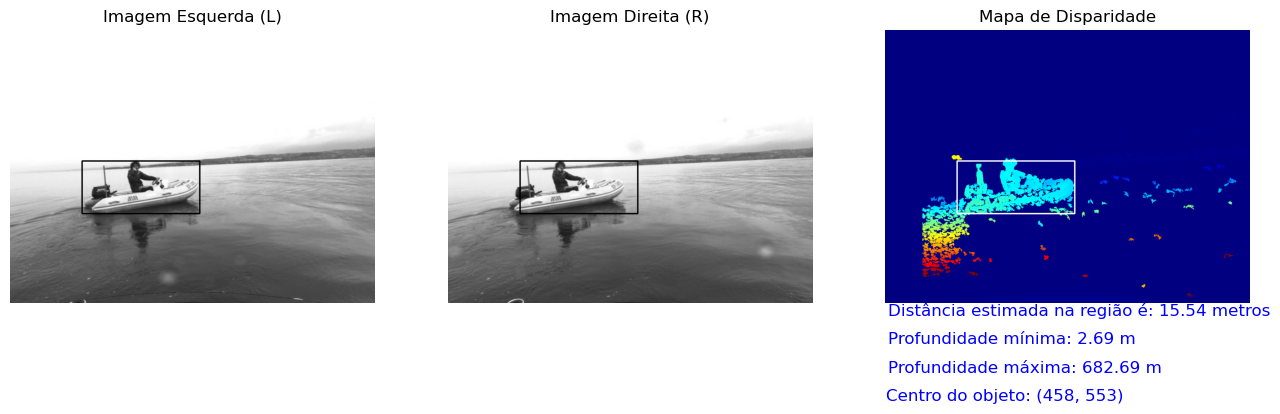

Angulo em relacao ao norte: 36.69913261659958º
Coordenadas do barco: 45.54761966523571, 13.705387316093407
Coordenadas do objeto: 45.54773177687149, 13.705506637615164


In [5]:
# cria o objeto DistanceMeter, responsavel por fazer o mapa de disparidade e calcular a distancia
distance_meter = DistanceMeter(focal_length, baseline)
# carrega os parametros da camera estereo
distance_meter.load_stereo_params(stereo_method_file)
# calcula a disparidade e a distancia do objeto
distance_meter.disparity_compute(imgL, imgR, (x, y), (w, h))
# plota os resultados, com ou sem os pontos extremos (disparidade minima e maxima)
distance_meter.plot_results(plot_extreme_points=False)

# cria o objeto GPSMarker, responsavel por calcular as coordenadas do objeto
gps_marker = GPSMarker(magnetic_declination)
# calcula o angulo do objeto em relacao ao centro da camera
gps_marker.angle_object(center_x, distance_meter.depth, imgL, focal_length)
# calcula as coordenadas do objeto
obj_latitude, obj_longitude = gps_marker.gps_mark(gps_path, imu_path, utm_zone=33)

print(f"Coordenadas do barco: {gps_marker.boat_coords[0]}, {gps_marker.boat_coords[1]}")
print(f"Coordenadas do objeto: {gps_marker.obj_coords[0]}, {gps_marker.obj_coords[1]}")

O ponto da estrela é o barco, enquanto o marcador azul é o do objeto.

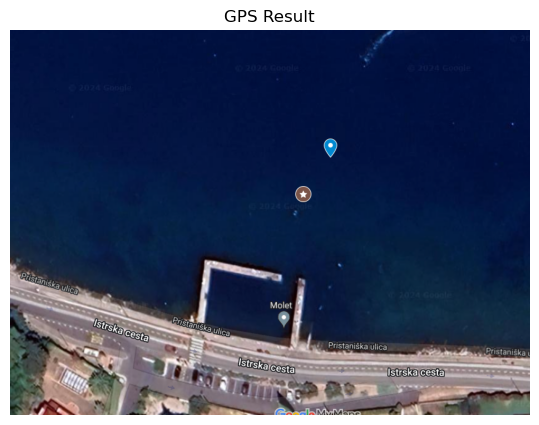

In [6]:
gps_result = cv2.imread("../results/gps.png")
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(gps_result, cv2.COLOR_BGR2RGB))
plt.title('GPS Result')
plt.axis('off')
plt.show()

In [6]:
def create_output(vertices, colors, filename):
	"""
	Função que cria um arquivo .ply da nuvem de pontos.

	Parâmetros:	
		vertices: coordenadas 3D dos pontos
		colors: cor dos pontos
		filename: nome do arquivo .ply
	"""

	# redimensiona o vetor de cores e de pontos
	colors = colors.reshape(-1, 3)
	vertices = np.hstack([vertices.reshape(-1, 3), colors])
	# define o cabeçalho do arquivo .ply
	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	# escreve o arquivo .ply
	with open(filename, 'w') as f:
		f.write(ply_header % dict(vert_num=len(vertices)))
		np.savetxt(f, vertices, '%f %f %f %d %d %d')

Com o mapa de disparidade calculado, a próxima etapa é obter os pontos 3D correspondentes. Para isso, é necessário calcular a matriz de reprojeção `Q` sendo obtida atráves de `cv2.stereoRectify()`, que leva em consideração os parâmetros intrínsecos e extrínsecos da câmera, obtidos na calibração. 

Com essa matriz, a função `cv2.reprojectImageTo3D()` pega os valores de disparidade e da matriz de reprojeção para obter pontos XYZ, obtendo a nuvem de pontos correspondente do mapa de disparidade. 

Após isso, é feito um processo de filtragem desses pontos, primeiramente são removidos pontos com valor infinito, posteriormente são criadas 2 máscaras, a primeira remove pontos de profundidade nula e a segunda exclui pontos que possuam o valor de profundidade maior que 80% do valor máximo. Com isso, a nuvem final de pontos foi filtrada e o seu valor foi dividido por 1000, para converter de mm para m.

A variável `output_colors` são as cores dos pixels da imagem, para que a nuvem de pontos possa ser visualizada com as cores originais dos pixels.

Para criar uma nuvem de pontos somente da ROI, primeiramente foi feita uma cópia do depth map original em `roi_map = np.copy(depth_map_gray)`, posteriormente foi criado uma máscara em que possui o mesmo tamanho de `roi_map`, porém fora da ROI possui valor 0. Após isso, foram feitos os mesmos processos de obtenção de nuvem de pontos e filtragem.



In [7]:
# converte a imagem de disparidade para escala de cinza
depth_map_gray = cv2.cvtColor(distance_meter.disparity_normalize, cv2.COLOR_BGR2GRAY)
# calcula a matriz de projeção Q
_, _, _, _, Q, _, _ = cv2.stereoRectify(Kl, Dl, Kr, Dr, (left_image.shape[1], left_image.shape[0]), R, T)
# reprojeta a imagem de disparidade para pontos 3D
points_3D = cv2.reprojectImageTo3D(depth_map_gray, Q)

# remove pontos com valor infinito
points_3D[points_3D == float('+inf')] = 0
points_3D[points_3D == float('-inf')] = 0

# cria uma mascara para remover pontos com z = 0
mask_map = (depth_map_gray > depth_map_gray.min()) 
# adiciona uma condicao para excluir pontos com z > 80% do valor maximo de z
max_z = points_3D[:, :, 2].max()  
mask_z = points_3D[:, :, 2] < (0.8 * max_z)  
# combina as mascaras
final_mask = mask_map & mask_z

# pega as cores da imagem esquerda e aplica a mascara
colors = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
output_colors = colors[final_mask]

# pega as coordenadas 3D dos pontos e aplica a mascara, converte de mm para metros
output_points = points_3D[final_mask]/1000

# cria uma copia da imagem de disparidade
roi_map = np.copy(depth_map_gray)

# cria uma mascara do mesmo tamanho da imagem de disparidade, que possui o valor 0 fora da regiao de interesse
mask = np.zeros_like(roi_map)
mask[y:y+h, x:x+w] = roi_map[y:y+h, x:x+w]
roi_map = mask

# reprojeta a imagem de disparidade para pontos 3D
roi_3D = cv2.reprojectImageTo3D(roi_map, Q)

# remove pontos com valor infinito
roi_3D[roi_3D == float('+inf')] = 0
roi_3D[roi_3D == float('-inf')] = 0

# aplica a mascara e converte de mm para metros
roi_points = roi_3D[final_mask]/1000

# gera o arquivo de nuvem de pontos
output_file = 'point_cloud1.ply'
create_output(output_points, output_colors, output_file)

Aqui a nuvem de pontos da imagem está sendo plotada em verde, e o ROI está sendo plotado em vermelho.

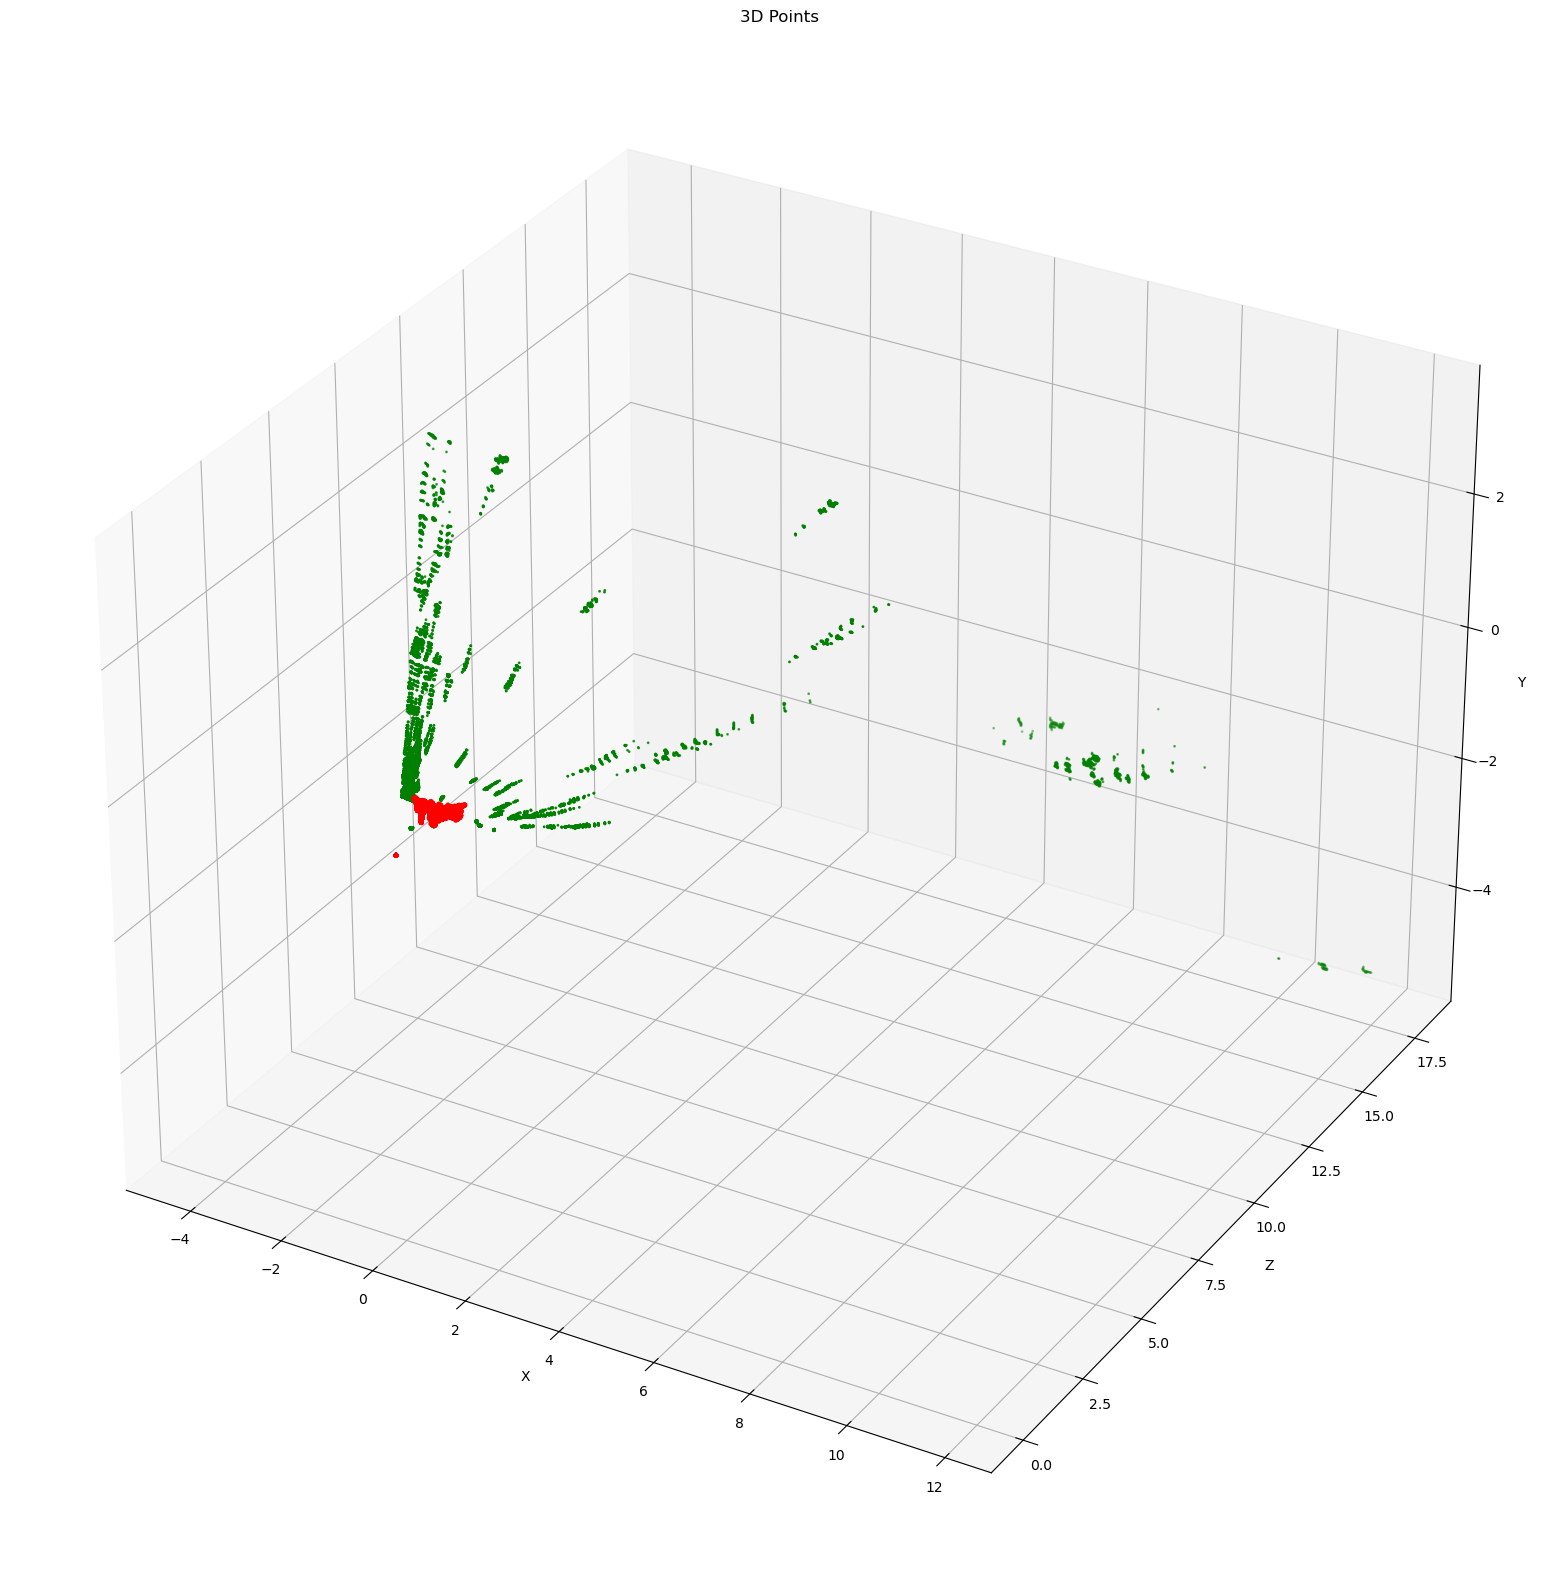

In [8]:
# plota os pontos 3D
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')

# plota os pontos 3D em verde
ax.scatter(output_points[:, 0], output_points[:, 2], output_points[:, 1], s=1, c='g')
# plota os pontos da ROI em vermelho
ax.scatter(roi_points[:, 0], roi_points[:, 2], roi_points[:, 1], s=5, c='r')

plt.title('3D Points')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()